In [1]:
import sys
import os

sys.path.append('/home/i40/renftlem/explainer-evaluation/src')
# Export updated path for pyspark
os.environ['PYTHONPATH'] = ":".join(sys.path)

In [2]:
import random
seed = 2372775446  # seed obtained with np.random.randint(0, 2 ** 32 -1 )
random.seed(seed)  # set seed so that petastorm read order becomes deterministic


In [3]:
import logging
from typing import Iterable
import numpy as np

from liga.experiments.experiment import Experiment, run_experiments
from liga.interpret.colors import PerceivableColorsInterpreter
from liga.interpret.common import JoinedInterpreter
from liga.interpret.ground_truth_objects import GroundTruthObjectsInterpreter
from liga.torch_extensions.classifier import TorchImageClassifier
from liga.type1.tree import TreeType1Explainer
from liga.type2.attribution import SaliencyType2Explainer, IntegratedGradientsType2Explainer, DeepLiftType2Explainer
from liga.liga import Type2Resampler, RandomCounterfactualResampler, DummyResampler
from liga.oiv4.metadata import OIV4MetadataProvider
from liga.places365.metadata import Places365Task

rng = np.random.default_rng(seed)

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
train_images_url = 'file:///home/i40/renftlem/openimages-v4-downsampled/' \
                   'parquet-stores/test-224x224-shuffled.parquet'
# test_images_url = 'file:///home/i40/renftlem/openimages-v4-downsampled/' \
#                   'parquet-stores/validation-224x224-shuffled.parquet'
# train_images_url = 'file:///home/renftlem/2020-[article]-evaluating-xai/' \
#                    'downsampled-open-images-v4/' \
#                    'parquet-stores/validation-sample-20000.parquet'
# test_images_url = 'file:///home/renftlem/2020-[article]-evaluating-xai/' \
#                   'downsampled-open-images-v4/' \
#                   'parquet-stores/validation-sample-20000.parquet'
p365_task = Places365Task()
oiv4_meta = OIV4MetadataProvider()


In [5]:
def get_interpreter():
    gt_obects_interpreter = GroundTruthObjectsInterpreter(gt_object_provider=oiv4_meta,
                                                          subset='test',
                                                          ignore_images_without_objects=True)
    color_interpreter = PerceivableColorsInterpreter()
    return JoinedInterpreter(gt_obects_interpreter, color_interpreter)


def get_type1_param_grid():
    return {
        'clf__max_depth': [30],
        'clf__ccp_alpha': (0., .001, .0025, .005, 0.01),
        'sel__threshold': ['mean'],  # was always better than median
        # # 'sel__estimator__n_estimators': [250],
        # 'sel__estimator__criterion': ['gini'],
        'sel__estimator__max_depth': [30],  # this is very important to keep memory consumption down (up to 35 is possible with few observations)
        # 'sel__estimator__min_impurity_decrease': [0.0001]  # avoids splits with very small gain
    }

In [ ]:
def get_proof_of_concept_experiments():
    classifier = TorchImageClassifier.from_json_file(path='places365_alexnet.json')
    interpreter = get_interpreter()
    resamplers = [Type2Resampler(IntegratedGradientsType2Explainer(classifier=classifier,
                                                                   interpreter=interpreter),
                                 max_concept_area=.2),
                  RandomCounterfactualResampler(classifier=classifier,
                                                interpreter=interpreter,
                                                num_counterfactuals=10,
                                                max_perturbed_area=.2),
                  DummyResampler(classifier=classifier,
                                 interpreter=interpreter)]

    for num_train_obs in [1000]:
        for resampler in resamplers:
            yield Experiment(rng,
                             repetitions=1,
                             images_url=train_images_url,
                             num_train_obs=num_train_obs,
                             num_test_obs=1000,
                             num_test_obs_for_counterfactuals=500,
                             num_counterfactuals=10,
                             max_perturbed_area=.2,
                             all_classes=p365_task.class_names,
                             type1=TreeType1Explainer(),
                             resampler=resampler)

run_experiments(name='proof_of_concept',
                description='Are the sophisticated methods better than the baseline?',
                experiments=get_proof_of_concept_experiments(),
                n_jobs=62,
                min_k_folds=5,
                max_k_folds=5,
                **get_type1_param_grid())

INFO:root:<Running experiment...>
INFO:root:-- <Parameters: {'classifier': 'alexnet', 'images_url': 'file:///home/i40/renftlem/openimages-v4-downsampled/parquet-stores/test-224x224-shuffled.parquet', 'num_train_obs': 1000, 'interpreter': 'Join(ground_truth_objects, perceivable_colors)', 'type1': 'tree', 'resampler': 'type2(igrad)', 'num_test_obs': 1000, 'num_test_obs_for_counterfactuals': 500, 'num_counterfactuals': 10, 'max_perturbed_area': 0.2}/>
INFO:root:-- <Caching test observations...>
INFO:root:-- <done/>
INFO:root:-- <Running LIGA...>
INFO:root:---- <Status update>
INFO:root:------ <Processed 129 observations/>
INFO:root:------ <LIGA's augmentation produced 395 additional observations./>
INFO:root:---- <done/>
INFO:root:---- <Status update>
INFO:root:------ <Processed 315 observations/>
INFO:root:------ <LIGA's augmentation produced 1037 additional observations./>
INFO:root:---- <done/>
INFO:root:---- <Status update>
INFO:root:------ <Processed 501 observations/>
INFO:root:----

In [ ]:
def get_all_experiments() -> Iterable[Experiment]:
    classifiers = ['places365_alexnet.json',
                   'places365_resnet18.json']

    interpreters = [get_interpreter()]

    type2_classes = [SaliencyType2Explainer,
                     IntegratedGradientsType2Explainer,
                     DeepLiftType2Explainer]

    type1_instances = [TreeType1Explainer()]

    for num_train_obs in [k * 1000 for k in [1, 2, 4, 8, 16, 32]]:
        for classifier_name in classifiers:
            classifier = TorchImageClassifier.from_json_file(path=classifier_name)
            for interpreter in interpreters:
                for type2_cls in type2_classes:
                    type2 = type2_cls(classifier=classifier,
                                      interpreter=interpreter)
                    for type1 in type1_instances:
                        yield Experiment(rng,
                                         repetitions=10,
                                         images_url=train_images_url,
                                         num_train_obs=num_train_obs,
                                         num_test_obs=15000,
                                         num_test_obs_for_counterfactuals=1000,
                                         num_counterfactuals=10,
                                         all_classes=p365_task.class_names,
                                         type1=type1,
                                         resampler=resampler)

run_experiments(name='alexnet_resnet18-varied_num_train_obs-10_reps',
                description='A run of all experiments.',
                experiments=get_all_experiments(),
                n_jobs=62,
                min_k_folds=5,
                max_k_folds=5,
                **get_type1_param_grid())

INFO:root:<Running experiment...>
INFO:root:-- <Parameters: {'classifier': 'alexnet', 'images_url': 'file:///home/i40/renftlem/openimages-v4-downsampled/parquet-stores/test-224x224-shuffled.parquet', 'num_train_obs': 1000, 'interpreter': 'Join(ground_truth_objects, perceivable_colors)', 'type1': 'tree', 'type2': 'none', 'num_test_obs': 15000}/>
INFO:root:-- <Caching test observations...>
INFO:root:-- <done/>
INFO:root:-- <Running LIGA...>
INFO:root:---- <Status update>
INFO:root:------ <Processed 1 observations/>
INFO:root:------ <LIGA's augmentation produced 0 additional observations./>
INFO:root:---- <done/>
INFO:root:---- <Fitting surrogate model...>
INFO:root:---- <done/>
INFO:root:-- <done/>
INFO:root:-- <Scoring surrogate model...>
INFO:root:---- <Classes {'chemistry lab', 'arena - hockey', 'fire station', 'trench', 'parking garage - indoor', 'stage - indoor', 'topiary garden', 'bow window - indoor', 'creek', 'construction site', 'bank vault', 'manufactured home', 'art studio', '

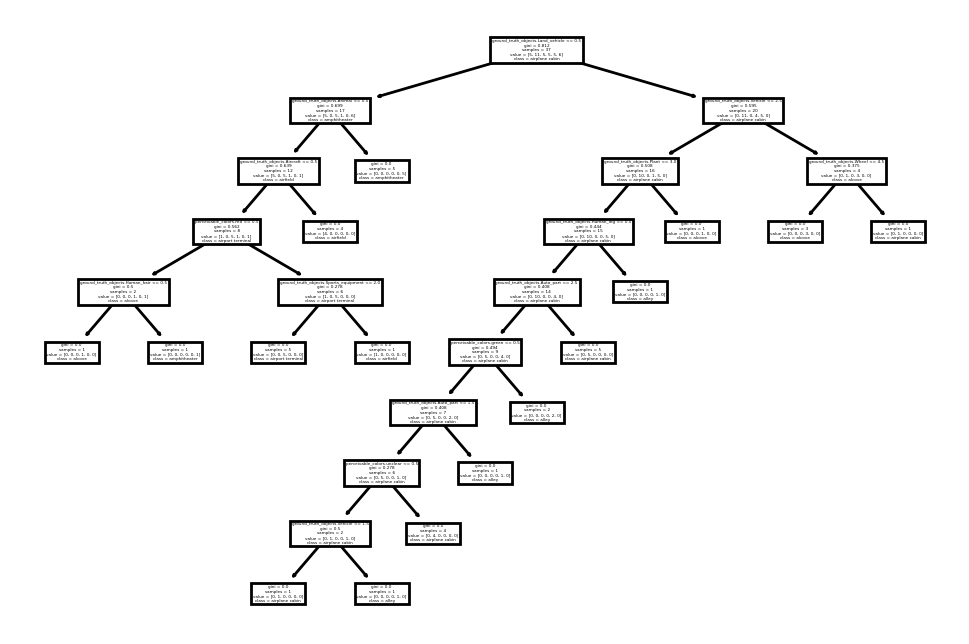

In [8]:
from matplotlib import pyplot as plt

fig = plt.gcf()
fig.set_dpi(200)
TreeType1Explainer.plot(experiment_name='2021-11-15-16:05:00 test',
                        exp_no=2,
                        all_classes=p365_task.class_names,
                        concepts=get_interpreter().concepts)

In [ ]:
# from petastorm.unischema import Unischema, UnischemaField
# from petastorm.etl.dataset_metadata import get_schema_from_dataset_url
#
#
# def _get_sanitized_schema_from_dataset_url(url: str):
#     # this hack is necessary to get a unischema whose fields have the correct hash function
#     # from an unpickled unischema :(
#     unpickled_schema = get_schema_from_dataset_url(url)
#     return Unischema(unpickled_schema._name, [UnischemaField(f.name, f.numpy_dtype, f.shape, f.codec, f.nullable)
#                                               for f in unpickled_schema.fields.values()])
#
#
# def randomize_image_order(images_url: str, output_url: str, seed: int):
#     spark_cfg = SparkSessionConfig('local[*]', '100G', '60G', '5G')
#     df = spark_cfg.session.read.parquet(images_url)
#     df = df.orderBy(sf.rand(seed=seed))
#     peta_schema = _get_sanitized_schema_from_dataset_url(images_url)
#     write_cfg = PetastormWriteConfig(output_schema=peta_schema,
#                                      output_url=output_url,
#                                      row_size=1024)
#     spark_cfg.write_petastorm(df, write_cfg=write_cfg)
#

In [ ]:
# randomize_image_order(images_url='file:///home/i40/renftlem/openimages-v4-downsampled/' \
#                                  'parq20uet-stores/test-224x224.parquet',
#                       output_url='file:///home/i40/renftlem/openimages-v4-downsampled/' \
#                                  'parquet-stores/test-224x224-shuffled.parquet',
#                       seed=seed)
#

In [ ]:
# randomize_image_order(images_url='file:///home/i40/renftlem/openimages-v4-downsampled/' \
#                                  'parquet-stores/validation-224x224.parquet',
#                       output_url='file:///home/i40/renftlem/openimages-v4-downsampled/' \
#                                  'parquet-stores/validation-224x224-shuffled.parquet',
#                       seed=seed)